# TP Séparateurs à vaste marge - SD-TSIA211

Ce TP a été réalisé par Théo Rouvet.

## 1 - Données

On commence par importer les données, je redirige pour cela le répertoire courant vers le dossier du TP dans ma machine.

In [1]:
import os
os.chdir(r"C:\Users\theor\OneDrive\Documents\Travaux\Télécom ParisTech ~ 2A\TSIA\SD-TSIA211\TP Séparateurs à vaste marge")

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import scipy.sparse
import scipy.sparse.linalg
from time import time

On récupère la fonction écrite dans le fichier annexe, qui va nous permettre de charger la base de données du dossier dans le notebook. On regarde rapidement ce que contiennent la matrice $X$ et le vecteur $y$, pour vérifier la cohérence avec ce qui est indiqué.

In [2]:
def load_breastcancer(filename):
    """
    Cette fonction lit le fichier filename, par exemple
    filename = 'wdbc_M1_B0.data'
    Elle retourne 
    X : une matrice de caracteristiques
    y : un vecteur des classes tel que si y[i] = 1, la tumeur est maligne
        et si y[i] = -1, la tumeur est benigne

    Pour plus d'infos sur la base de donnees,
    https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Prognostic%29
    """

    data = np.loadtxt(filename, delimiter=',')

    # la colonne 0 ne nous interesse pas ici
    y = data[:, 1] * 2 - 1
    X = data[:, 2:]

    # Standardisation de la matrice
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    return X, y

X, y = load_breastcancer('./wdbc_M1_B0.data')
print("Caractéristiques:", X[0])
print()
print("Classes:", y[:40])

Caractéristiques: [ 1.09706398 -2.07333501  1.26993369  0.9843749   1.56846633  3.28351467
  2.65287398  2.53247522  2.21751501  2.25574689  2.48973393 -0.56526506
  2.83303087  2.48757756 -0.21400165  1.31686157  0.72402616  0.66081994
  1.14875667  0.90708308  1.88668963 -1.35929347  2.30360062  2.00123749
  1.30768627  2.61666502  2.10952635  2.29607613  2.75062224  1.93701461]

Classes: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1.  1.  1.]


## 2 - Méthode du sous gradient

### Question 2.1

On note : 

$$\begin{align}
A(v, a, \xi) &=  \frac{1}{2} \sum_{j=1}^m v_j^2 + c\sum_{i=1}^n \xi_i \\
B(v,a) &= \frac{1}{2} \sum_{j=1}^m v_j^2 + c\sum_{i=1}^n max(0, 1-y_i(x_i^Tv + a)) 
\end{align}$$

avec $c=1$.

* D'après les contraintes du problème $ (1)
$ : $ \forall i \in \{1,...,n\}, \xi_i \geqslant \text{max}(0, 1-y_i(x_i^Tv + a))  $. Ainsi, on obtient par calcul rapide que $ A(v,a, \xi) \geqslant B(v,a) $ (les termes sommés étant positifs), d'où $ \underset{v\in \mathbb{R}^m, a \in \mathbb{R}, \xi \in \mathbb{R}^n}{\text{min}} A(v,a, \xi)  \geqslant \underset{v\in \mathbb{R}^m, a \in \mathbb{R}}{\text{min}} B(v,a) $.


* Pour tout $(a_0, v_0)$ fixé, en  prenant $ \forall i \in \{1,...,n\}, \xi_i^* = \text{max} (0, 1-y_i(x_i^Tv_0 + a_0)) $ , on a directement $ A(v_0,a_0,\xi^*) = B(v_0,a_0) $ d'où $ \underset{v\in \mathbb{R}^m, a \in \mathbb{R}, \xi \in \mathbb{R}^n}{\text{min}} A(v,a, \xi)  \leqslant A(v_0,a_0,\xi^*) = B(v_0,a_0) $, ce qui entraîne $\underset{v\in \mathbb{R}^m, a \in \mathbb{R}, \xi \in \mathbb{R}^n}{\text{min}} A(v,a, \xi)  \leqslant \underset{v'\in \mathbb{R}^m, a' \in \mathbb{R}}{\text{min}} B(v',a')$ par minimisation du terme de droite.

**Ces deux points prouvent la double inégalité, on peut donc en déduire que** : 

$$ \underset{v\in \mathbb{R}^m, a \in \mathbb{R}, \xi \in \mathbb{R}^n}{\text{min}} A(v,a, \xi)  = \underset{v\in \mathbb{R}^m, a \in \mathbb{R}}{\text{min}} B(v,a) $$

De plus, la double inégalité a montré qu'on pouvait fabriquer l'optimum de l'un à partir de celui de l'autre facilement (le lien étant entre les contraintes du problème $(1)$ et l'expression de la seconde somme du problème $(2)$. Ceci conclut donc sur **l'équivalence des deux problèmes considérés**.

### Question 2.2

On trace la fonction $h$, et on en déduit graphiquement les pentes possibles.

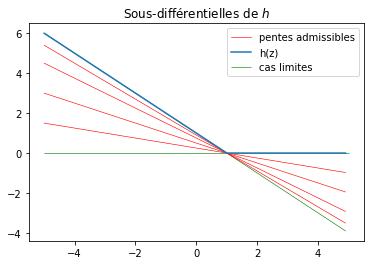

In [3]:
def h(z):
    return max(0,1-z)

z = np.arange(-5, 5, 0.1)
hValues = np.fmax(0, 1-z)

plt.plot(z, -1 * z +1, linewidth = 0.6, color = 'green')
plt.plot(z, -0.25* z + 0.25, linewidth = 0.6, color = 'red')
plt.plot(z, -0.5* z + 0.5, linewidth = 0.6, color = 'red')
plt.plot(z, -0.75* z + 0.75, linewidth = 0.6, color = 'red')
plt.plot(z, -0.9* z + 0.9, linewidth = 0.6, color = 'red', label = "pentes admissibles")
plt.hlines(0, -5,5, linewidth = 0.6, color = 'green', label = "cas limites")

plt.plot(z, hValues, label = 'h(z)')
plt.title("Sous-différentielles de $h$")
plt.legend()
plt.show()

On définit $h : z \mapsto \text{max}(0, 1-z)$ sur $\mathbb{R}$.

* $ \forall z \in ]- \infty, 1[, h(z) = 1-z $ donc **la fonction $h$ est différentiable** sur cet intervalle. La sous-différentielle de $h$ vaut donc $\{-1\}$ ici, i.e. la dérivée de $h$ (car elle est différentiable ici).


* De même, dans l'intervalle $ ]1, +\infty[ $, la sous-différentielle de la fonction $ h $ vaut $\{0\}$.


* En $z = 1 $, **les valeurs admissibles de sous-gradient sont les pentes entre $ -1 $ et $ 0 $**, donc la sous-différentielle vaut $ [-1,0] $. Les droites rouges représentent des pentes admissibles, les droites vertes sont les pentes extrêmes admissibles.

### Question 2.3

On définit $f(v, a) = \frac{1}{2} \sum_{j=1}^m v_j^2 + c \sum_{i=1}^n \text{max}(0, y_i(x_i^Tv+a))$. On cherche à l'écrire sous la forme $f(v, a) = N(v,a) + cH(M(v,a)) $ avec $M$ une application linéaire et $N$ et $H$ deux fonctions séparables.

On pose tout d'abord $$ N(v,a) =  \sum_{j=1}^m \frac{v_j^2}{2} = \sum_{j=1}^m n_j(v_j)$$ dont on vérifie immédiatement la séparabilité.

De plus, on pose 
$$ \begin{align}
H(Z) &= \sum_{i=1}^n max(0, 1-z_i) \\
\\
M &= \left( \begin{array}{c}
y_1x_1^T ~~~ y_1\\
\vdots \\
y_ix_i^T ~~~ y_i  \\
\vdots \\
y_nx_n^T ~~~ y_n
\end{array} \right) \\
\\
\text{ d'où }M(v, a) &= \left( y_0(x_0^Tv + a), ..., y_n(x_n^Tv + a)\right) \text{ avec } 1_n = (1,...,1)^T
\end{align}$$


Il est également immédiat que $M$ est linéaire et que $H$ est séparable. 

En outre, on vérifie bien que $f(v, a) = N(v,a) + cH(M(v,a)) $. Ainsi, les fonctions proposées conviennent.

Nous vérifions ainsi les hypothèses de la propriété 2.4.2, donc :

$$ \partial f(v,a) = \partial N(v,a) + cM^T\partial H(M(v,a)) $$

En différentiant $N$, on obtient que : $$\partial N(v,a) = \left( \begin{array}{c}
v\\
0
\end{array} \right) $$

On peut également utiliser le fait que $H$ soit séparable : $$ \partial H(x) = \partial h(x_1) \times ... \times \partial h(x_n)$$

### Question 2.4

On commence par coder toutes les fonctions auxiliaires que l'on a utilisées pour définir $f$.

In [4]:
X_bis = np.c_[X,np.ones((X.shape[0],1))]
n,m = X_bis.shape
# X avec une colonne de 1, prenant en compte l'intercept

def N(nu,a):
    tab = np.array([0.5*nu_i*nu_i for nu_i in nu])
    return np.sum(tab)

def H(Z):
    tab = np.array([max(0,1-z) for z in Z])
    return np.sum(tab)

M1 = np.array([y[i]*X_bis[i,:] for i in range(n)])

def M(nu,a):
    return np.dot(M1,((np.append(nu,a))))

On utilise ensuite la relation de la question précédente afin de coder une fonction qui renvoie la sous-différentielle de $f$ en tout point.

In [5]:
def subdiff_f(nu, a, c = 1):
    
    # define f
    f = N(nu,a) + c*H(M(nu,a))
    
    # subgrad of f
    subgrad_h = -(M(nu,a)<=1).astype(int)
    sub_grad_f = np.append(nu,0) + c*M1.T@subgrad_h
    
    return f, sub_grad_f

In [6]:
value, subgrad_value = subdiff_f(np.ones((m-1,1)), 5)
print(value)
print(subgrad_value)

805.9216593522436
[-56.40540055 -15.89543571 -52.1917259  -53.28963475  42.5570023
  37.14060713   9.9615454  -13.69296926  37.47738396  93.76756606
 -17.89685698  43.78975209 -12.51863391 -27.97924058  77.70463015
  81.62584304  70.03113097  60.42013469  52.11666728  99.72326511
 -58.42234145 -24.97106338 -53.15719928 -53.75186403  20.28446251
  17.94795003  10.60158241 -13.58739269  -6.89787984  50.42977457
  74.        ]


### Question 2.5

On applique la méthode du sous-gradient, en se basant sur l'énoncé et la question précédente, et on prend comme conditions initiales $(v_0,a_0) = 0$ avant d'exécuter l'algorithme.

In [7]:
def subgradient_method(nu_0,a_0,k):
    
    nu_i = nu_0[:,0]
    a_i = a_0
    
    for i in range(k):
        
        # on choisit un élément de la sous-différentielle
        result, subgrad = subdiff_f(nu_i,a_i)
        
        # on prend le nouveau point avec le pas 1/(i+1) comme indiqué
        nu_i = nu_i[:m-1] - subgrad[:m-1]/(i+1)
        a_i = a_i - subgrad[m-1]/(i+1)
        
    return result

In [8]:
debut = time()
print("Valeur :", subgradient_method(np.zeros((m-1,1)), 0, 10**4))
print("Temps d'exécution :", time()-debut)

Valeur : 26.570582119490396
Temps d'exécution : 6.529015779495239


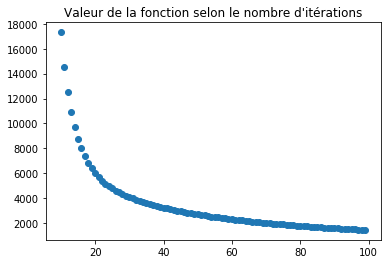

In [9]:
ordonn = np.array([subgradient_method(np.zeros((m-1,1)), 0, k) for k in range(10,10**2)])
abscis = np.arange(10, 10**2, 1)

plt.scatter(abscis, ordonn)
plt.title("Valeur de la fonction selon le nombre d'itérations")
plt.show()

L'algorithme prend des valeurs très grandes tout d'abord puis décroit rapidement. On peut noter que l'exécution est rapide pour $10~000$ itérations, et que la valeur obtenue change peu passé ce seuil (moins d'un pourcent d'écart relatif lors de l'exécution avec $100~000$ itérations). 

## 3 - Méthode du sous-gradient stochastique

### Question 3.1

On a $I \sim U(\{1,...,n\})$. On peut donc calculer l'espérance en utilisant le théorème de transfert.

On a tout d'abord, par définition de l'espérance et de $I$ : 
$$ \mathbb{E}[f_I(v,a)] = \sum\limits_{i=1}^n P(I=i)f_i(v,a) = \frac{1}{n}\sum\limits_{i=1}^n f_i(v,a) $$ 

On a ensuite, en utilisant la formule de $f_i$ donnée : 
$$ \mathbb{E}[f_I(v,a)] = \frac{1}{2}\sum\limits_{i=1}^m v_j^2 +\frac{1}{n}cn\sum\limits_{i=1}^n max(0,1 - y_i(x_i^Tv+a)) $$

D'où finalement : $$\mathbb{E}[f_I(v,a)] = f(v,a) $$

### Question 3.2

On peut poser $M_i = \left( \begin{array}{c}
0\\
\vdots \\
(y_ix_i^T ~~~ y_i)  \\
\vdots \\
0
\end{array} \right)$. 


On utilise $M_i$ à la place de $M$ et $c*n$ à la place de $c$ dans la preuve de la formule du sous-gradient (de la partie précédente). 

On a donc :
$$ \partial f_i(v,a) =  \left( \begin{array}{c}
v\\
0
\end{array} \right)  + cnM_i^T \partial H(M_i\left( \begin{array}{c}
v\\
a
\end{array} \right)) 
= \left( \begin{array}{c}
v\\
0
\end{array} \right)  + cnM_i^T \partial H\left( \begin{array}{c}
0\\
\vdots \\
(y_ix_i^Tv + y_ia)  \\
\vdots \\
0
\end{array} \right)
=
\left( \begin{array}{c}
v\\
0
\end{array} \right)  + cnM_i^T \left( \begin{array}{c}
-1\\
\vdots \\
\partial h(y_ix_i^Tv + y_ia)  \\
\vdots \\
-1
\end{array} \right) $$

Ainsi, on obtient que :
$$
\partial f_i(v,a)  =
\left( \begin{array}{c}
v\\
0
\end{array} \right)  + cny_i \partial h(y_ix_i^Tv + y_ia) \left( \begin{array}{c}
x_i\\
1
\end{array} \right)
$$

### Question 3.3

Pour coder cet algorithme, nous allons tirer à chaque itération $k$ un entier $i_k$ et prendre $x_{k+1} = x_k - \gamma_k g_k$ où $g_k \in \partial f_{i_k}(x_k)$.
On fixe le pas à $1/K ^{1/2}$ où $K$ est nombre d'itérations, comme suggéré dans le poly.

Cette méthode est donc similaire à l'approche de la partie précédente, avec un côté aléatoire dans le choix de $f_i$.

In [10]:
from random import randint


def subgrad_f_i(v,a,i):
    
    subgrad_h = -(y[i]*(X[i,:]@v + a)<=1).astype(int)
    
    subgrad_f_i = np.append(v,0) + n*y[i]*subgrad_h*np.append(X[i,:],1)
    f_i = v.T@v/2 + n * h(y[i]*(X[i,:]@v + a))
    
    return f_i, subgrad_f_i

def stochastic_subgradient_method(nu_0, a_0, K):
    nu_k = nu_0[:,0]
    a_k = a_0
    
    b = 6*10**(-4) # on choisit empiriquement une constante
    step = b/np.sqrt(K)
    total_step = 0
    
    weighted_value_nu = 0
    weighted_value_a = 0
    
    for k in range(K):
        
        # choix aléatoire de i dans {1,...,n}
        i = randint(0,n-1)
        result, sub = subgrad_f_i(nu_k,a_k,i)
        
        total_step += step
        
        weighted_value_nu += nu_k*step
        weighted_value_a += a_k*step
        
        nu_k = nu_k[:m-1] - sub[:m-1]*step
        a_k = a_k - sub[-1]*step
    
    f_value,_ = subdiff_f(weighted_value_nu/total_step , weighted_value_a/total_step)

    return f_value

On effectue tout d'abord le test avec $10~000$ itérations comme précédemment.

In [11]:
debut = time()
print("Valeur :", stochastic_subgradient_method(np.zeros((m-1,1)), 0,10**4))
print("Temps d'exécution :", time()-debut)

Valeur : 36.24984734250739
Temps d'exécution : 0.29809093475341797


Comme la méthode est très rapide, on peut augmenter le nombre d'itérations :

In [12]:
debut = time()
print("Valeur :", stochastic_subgradient_method(np.zeros((m-1,1)), 0,5*10**5))
print("Temps d'exécution :", time()-debut)

Valeur : 28.84140332580188
Temps d'exécution : 14.573121070861816


L'algorithme du gradient stochastique est très rapide, bien plus que la méthode du sous-gradient pour le même nombre d'itérations. Cependant, pour 50 fois plus d'itérations que la méthode du sous-gradient, on obtient a priori un moins bon résultat.

**Cette méthode améliore donc la vitesse d'exécution mais ralentit la vitesse de convergence par rapport à la méthode du sous-gradient.**

## 4 - Méthode du lagrangien augmenté

### Question 4.1 

Le Lagrangien du problème (1) peut s'écrire, pour tout $\phi \in \textbf{R}^{2n}$ : 

$$ L(v,\xi ; \phi) = \left(\frac{1}{2}\sum\limits_{i=0}^mv_j^2 + c\sum\limits_{i=0}^n\xi_i \right) + \left(\sum\limits_{i=0}^n[ -\xi_i\phi_i +\phi_{i+n}(1 - y_{i+n}(x_{i+n}^Tv+a) - \xi_{i+n})]\right) - \sum\limits_{i=0}^{2n} \iota_{\textbf{R}_+}(\phi_i) $$

en regroupant les termes de contrainte d'inégalité. 

### Question 4.2

On a posé $g : (x, \phi) \mapsto -\frac{1}{2\rho}\phi^2 + \frac{\rho}{2}(\text{max}(0,x + \rho^{-1}\phi))^2$.

En prolongeant la dérivée de $ x \mapsto max(0,x)^2$ par continuité en 0, on obtient qu'il s'agit d'une fonction continuement dérivable en 0, de dérivée $ x \mapsto 2max(0,x)$.

Par conséquent, on peut dériver en utilisant les règles usuelles de composition. On obtient ainsi :

$$\begin{align} 
\nabla_xg(x,\phi) &= \rho \text{max}(0,x + \rho^{-1}\phi) \\
\\
\nabla_{\phi}g(x,\phi) &= -\rho^{-1}\phi + \frac{\rho}{\rho} \text{max}(0,x + \rho^{-1}\phi) = \text{max}(-\rho^{-1}\phi,x )
\end{align}$$

### Question 4.3
On a que $ x \mapsto \nabla_xg(x,\phi) = \rho \text{max}(0,x + \rho^{-1}\phi)  $ est une fonction croissante sur $\mathbb{R}$ (car $\rho > 0$), on a donc la convexité de $x \mapsto g(x,\phi)$ quel que soit $\phi$.

De même, $ \phi \mapsto \nabla_{\phi}g(x,\phi) = \text{max}(-\rho^{-1}\phi,x ) $ est décroissante (car $-\rho < 0$), on a donc la concavité de $\phi \mapsto g(x,\phi)$ quel que soit $x$.

### Question 4.4

Nous allons coder la méthode du gradient afin de minimiser le Lagrangien par rapport à $v$, $a$ et $\xi$. Avant de commencer à itérer, nous allons expliciter le gradient du Lagrangien $L$ dans ces 3 directions : 

$$\begin{align} 
\nabla_vL(v,a,\xi,\phi,\psi) &= v - \sum\limits_{i=1}^n y_ix_i \rho max(0, -\xi_i + 1 - y_{i}(x_{i}^Tv+a) + \phi_i\rho^{-1}) \\
\\
\nabla_aL(v,a,\xi,\phi,\psi) &= - \sum\limits_{i=1}^n y_i \rho max(0, -\xi_i + 1 - y_{i}(x_{i}^Tv+a) + \phi_i\rho^{-1}) \\ 
\\
\nabla_{\xi}L(v,a,\xi,\phi,\psi) &= c - (\rho max(0, \rho^{-1}\phi_i - \xi_i))_i- ( \rho max(0, -\xi_i + 1 - y_{i}(x_{i}^Tv+a) + \phi_i\rho^{-1}))_i
\end{align}$$ 


En utilisant cette information, on utilise la méthode du gradient sur le Lagrangien :


In [30]:
def grad_x_g(x,phi,rho):
    return rho * np.maximum(0, x + phi/rho)

def gradient_lagrangien(phi, psi, epsilon = 1, rho = 2):
    
    nu, a, xi = np.zeros(m-1),epsilon +1, np.zeros(n)
    
    N = 1 - M(nu,a)


    grad_nu = nu - (M1.T@grad_x_g(N-xi,phi,rho))[:-1]
    grad_a = - y.T@grad_x_g(N-xi,phi,rho)     
    grad_xi = 1 - grad_x_g(-xi,phi,rho) - grad_x_g(N-xi,phi,rho)

    norm = grad_a**2 + np.sum(grad_nu**2) + np.sum(grad_xi**2)
    
    k=1
    
    while (norm > epsilon**2):
        grad_nu = nu - (M1.T@grad_x_g(N-xi,phi,rho))[:-1]
        grad_a = - y.T@grad_x_g(N-xi,phi,rho)     
        grad_xi = 1 - grad_x_g(-xi,phi,rho) - grad_x_g(N-xi,phi,rho)
         
        norm = grad_a**2 + np.sum(grad_nu**2) + np.sum(grad_xi**2)
        nu = nu - grad_nu/750     
        a = a - grad_a/750         
        xi = xi - grad_xi/750
        N = 1- M(nu,a)

        k+=1
            
    return nu, a, xi

### Question 4.5

On a par calcul direct que : 

$$\begin{align}  
\nabla_{\phi}L(v,a,\xi,\phi,\psi) &= (max( - \frac{\phi_i}{\rho}, -\xi_i)) \\
\\
\nabla_{\psi}L(v,a,\xi,\phi,\psi) &= (max( - \frac{\psi_i}{\rho}, -\xi_i + 1 - y_{i}(x_{i}^Tv+a)))
\end{align}$$ 

On cherche ensuite à coder ce résultat : 

In [25]:
def grad_phi_g(x, phi, rho):
    return np.maximum(-phi/rho, x)

def grad_phi_psi(nu, a, xi, phi, psi, rho):    
    
    grad_phi = grad_phi_g(-xi,phi,rho)
    
    grad_psi = grad_phi_g(-xi + 1-M(nu,a), psi, rho)
    
    return grad_phi, grad_psi

### Question 4.6

On code enfin la méthode du lagrangien augmenté (Augmented Lagrangian Method) et on mesure ses résultats :

In [34]:
def ALM(phi0, psi0, eps = 1, rho = 2, nb_iter  = 2000):
    
    phi, psi = phi0, psi0
    
    for k in range(nb_iter):
        
        nu, a, xi = gradient_lagrangien(phi,psi,eps,eps)
        grad_phi, grad_psi = grad_phi_psi(nu, a, xi, phi, psi, rho)
        
        phi += rho*grad_phi
        psi += rho*grad_psi
    
    return nu, a, xi

In [38]:
debut = time()
test_nu,test_a,test_xi = ALM(np.zeros(n),np.zeros(n))
print("Temps d'exécution :", time()-debut)

Temps d'exécution : 254.81454467773438


In [39]:
subdiff_f(test_nu, test_a)[0]

28.464571080831973

## 5 - Comparaison

### Question 5.1

Nous allons comparer ces différentes méthodes en termes de résultat et de vitesse d'exécution.

On peut recenser ces informations sous forme de tableau :

|  | Méthode du sous-gradient classique |  Méthode du sous-gradient stochastique  | Méthode du sous-gradient stochastique | Méthode du lagrangien augmenté  |   |
|---|---|---|:-:|---|---|
| Résultat final  | 26.570582119490396  | 36.24984734250739 | 28.84140332580188 | 28.464571080831973   |   |
| Temps d'exécution  | 6.529015779495239 s| 0.29809093475341797 s| 14.573121070861816 s| 254.81454467773438 s|   |
| Nombre d'itérations  | $10~000$ | $10~000$ | $500~000$ | $2~000$ |   |

A la lumière de ces résultats, nous pouvons dire que :


* la méthode du sous-gradient fournit le meilleur résultat, pour un temps de $6.5$ secondes et $10~000$ opérations.


* la méthode du sous-gradient stochastique est la plus rapide (moins de 0.3 secondes) mais fournit un moins bon résultat que la méthode précédente, même avec $500~000$ itérations.


* la méthode du lagrangien augmentée est de loin la plus longue (plus de 4 minutes pour $2~000$ itérations). Le résultat obtenu in fine n'est pas meilleur que celui de la première méthode.


Pour conclure, il semble que le meilleur compromis entre temps d'exécution et précision du résultat soit d'utiliser la première méthode, i.e. la **méthode du sous-gradient classique**.